In [1]:
!pip install noisereduce

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [46]:
from scipy.io import wavfile
import scipy
import os
from IPython.display import Audio, display
import noisereduce as nr
from scipy.fft import fft, fftfreq
from scipy.signal import butter, sosfiltfilt
import matplotlib.pyplot as plt
import numpy as np
import glob
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import pandas as pd
import pickle
import librosa
import random

# PHASE 1

In [14]:
def noise_reduction(path):
  rate, audio = wavfile.read(path)
  sos = butter(10, [75, 3500], analog=False,fs=rate, btype='band', output='sos')
  filtered = sosfiltfilt(sos, audio)
  wave = nr.reduce_noise(y = filtered, sr=rate,stationary=True,n_fft=256)
  return wave

In [12]:
def silence_trim(wave):
  start = 0
  end = len(wave)
  #print(abs(max(wave[50:-50]))) #ignore unwanted picks at the end and beginning
  for idx, point in enumerate(wave):
    #first sample which is greater than 0.1*max is the start point
    if abs(point) > 0.1*abs(max(wave[50:-50])): 
      if idx > 100:
        start = idx
        break

  # Reverse the array for trimming the end
  for idx, point in enumerate(wave[::-1]):
    #last sample which is greater than 0.1*max is the end point
    if abs(point) > 0.1*abs(max(wave[50:-50])):
      if idx > 200:
        end = len(wave) - idx
        break
  trimmed = wave[start:end]
  return trimmed

In [13]:
def preprocess(root, padd=0):
  X = [] #list to save trimmed signals with different length
  y = [] #list to assign labels according to subdirectory

  for i in range(10):
    path = os.path.join(root,str(i))
    for file in glob.glob(os.path.join(path,'*.wav')):
      wave = noise_reduction(file)
      trimmed = silence_trim(wave)
      X.append(trimmed.tolist())
      y.append(i)

  length = len(max(X,key=len)) #padding train data with max length
  if(padd != 0): #padding test data with maximum length of "train" data
    length = padd
  print(length)
  print()
  X_pad = np. zeros((len(X),length)) #2D array for equal size train(test) data
  for j in range(len(X)):
    audio = np.asarray(X[j]) #convert list back to numpy
    #print(audio.shape[0])
    #pad the end of signal with zeros
    audio = np.pad(audio,(0,length-audio.shape[0]),'constant',constant_values=(0,0))
    X_pad[j] = audio

  y = np.asarray(y)

  return X_pad,y, length


In [31]:
root = os.getcwd()
dataset_path = os.path.join(root,'Dataset')
phase1_path = os.path.join(root,'Phase_1')
phase2a_path = os.path.join(root,'Phase_2a')
phase2b_path = os.path.join(root,'Phase_2b')
phase3_path = os.path.join(root,'Phase_3')
train_path = os.path.join(dataset_path,'train')
test_path = os.path.join(dataset_path,'test')

In [ ]:
X_train,y_train,len_train = preprocess(train_path)
np.save(os.path.join(phase1_path,'phase1_Xtrain.npy'),X_train)
np.save(os.path.join(phase1_path,'phase1_ytrain.npy'),y_train)
print(X_train.shape)
print(y_train.shape)

X_test,y_test,len_test = preprocess(test_path,len_train)
np.save(os.path.join(phase1_path,'phase1_Xtest.npy'),X_test)
np.save(os.path.join(phase1_path,'phase1_ytest.npy'),y_test)
print(X_test.shape)
print(y_test.shape)

# fig = plt.figure(figsize=(14, 45))
# for i in range(X_train.shape[0]):
#     time = np.linspace(0., X_train.shape[1]/8000, X_train.shape[1])
#     ax = fig.add_subplot(X_train.shape[0],1,i+1)
#     plt.grid(axis = 'y')
#     plt.plot(time,X_train[i])
# plt.show()

4783

(2000, 4783)
(2000,)
4783

(500, 4783)
(500,)


# PHASE 2 a

## الف)

In [7]:
X_train = np.load(os.path.join(phase1_path,'phase1_Xtrain.npy'))
y_train = np.load(os.path.join(phase1_path,'phase1_ytrain.npy'))
print(X_train.shape)
print(y_train.shape)


(2000, 4783)
(2000,)


In [8]:
X_test = np.load(os.path.join(phase1_path,'phase1_Xtest.npy'))
y_test = np.load(os.path.join(phase1_path,'phase1_ytest.npy'))
print(X_test.shape)
print(y_test.shape)

(500, 4783)
(500,)


In [9]:
scalar = StandardScaler()
X_train_scale = scalar.fit_transform(X_train)
X_test_scale = scalar.transform(X_test)

In [40]:
pca = PCA() #n_components = n_samples = 2000 
pca.fit(X_train_scale);
evr = pca.explained_variance_ratio_ #how much information each feature holds compared to others

In [41]:
print(evr.cumsum()[0:2000:50])
print(evr.shape)

[0.13719439 0.67818515 0.80013019 0.86458341 0.90434454 0.93085616
 0.94914157 0.96219883 0.97174105 0.97883095 0.98410242 0.98805202
 0.99104354 0.99330342 0.99502232 0.99633506 0.99733359 0.99808029
 0.99862994 0.99903372 0.99932738 0.99954077 0.99968975 0.999794
 0.99986508 0.99991269 0.99994439 0.99996577 0.99997954 0.99998819
 0.99999348 0.99999659 0.99999834 0.99999925 0.9999997  0.99999989
 0.99999997 0.99999999 1.         1.        ]
(2000,)


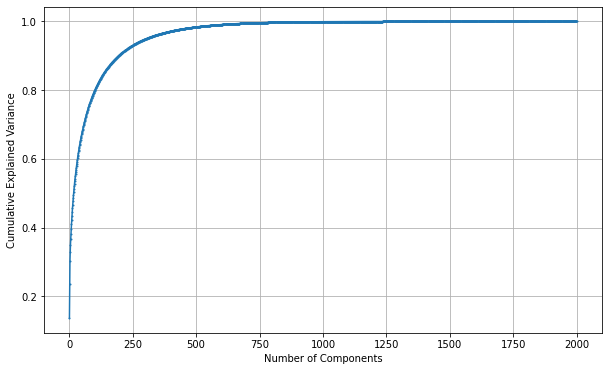

In [46]:
#cumulative plot to choose an optimum n_components with least omitted data
fig = plt.figure(figsize=(10,6))
plt.plot(range(1, X_train.shape[0]+1), evr.cumsum(), marker='o',markersize=1)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [10]:
pca = PCA(n_components=300)
X_train_pca = pca.fit_transform(X_train_scale)
X_test_pca = pca.transform(X_test_scale)
print(X_train_pca.shape)

(2000, 300)


In [12]:
param_grid = {
    'max_depth': [20, 30, 40, 50, 60],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 400, 500],
    'max_features': [70, 90, 110, 130, 150]
}

rf = RandomForestClassifier()

clf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid,
                         cv = 5, scoring='accuracy', n_iter=50, n_jobs = -1,
                   verbose=2, random_state=0,return_train_score=True)
clf.fit(X_train_pca, y_train)
pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,parameters,validation_score,train_score,rank
0,"{'n_estimators': 300, 'min_samples_split': 12,...",0.3055,0.992125,41
1,"{'n_estimators': 300, 'min_samples_split': 12,...",0.2965,0.990500,49
2,"{'n_estimators': 400, 'min_samples_split': 10,...",0.3205,0.996000,6
3,"{'n_estimators': 400, 'min_samples_split': 10,...",0.3105,0.990750,29
4,"{'n_estimators': 300, 'min_samples_split': 10,...",0.3140,0.990625,19
5,"{'n_estimators': 500, 'min_samples_split': 12,...",0.3160,0.994125,11
6,"{'n_estimators': 300, 'min_samples_split': 8, ...",0.3100,0.997375,30
7,"{'n_estimators': 300, 'min_samples_split': 10,...",0.3060,0.997125,39
8,"{'n_estimators': 400, 'min_samples_split': 8, ...",0.3240,0.997750,3
9,"{'n_estimators': 500, 'min_samples_split': 8, ...",0.3250,0.994500,1


In [18]:
df = pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})
df_path = os.path.join(phase2a_path,'cv_result_phase2a_pca300.csv')
df.to_csv(df_path, index=False)

# ب)

In [13]:
print(clf.best_params_)
y_pred = clf.predict(X_test_pca)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 5, 'max_features': 110, 'max_depth': 30}

0.352

              precision    recall  f1-score   support

           0       0.42      0.86      0.56        50
           1       0.28      0.14      0.19        50
           2       0.29      0.34      0.31        50
           3       0.23      0.16      0.19        50
           4       0.31      0.16      0.21        50
           5       0.30      0.12      0.17        50
           6       0.62      0.48      0.54        50
           7       0.43      0.36      0.39        50
           8       0.31      0.42      0.36        50
           9       0.28      0.48      0.36        50

    accuracy                           0.35       500
   macro avg       0.35      0.35      0.33       500
weighted avg       0.35      0.35      0.33       500




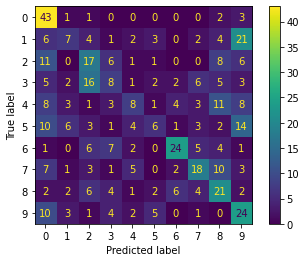

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
plt.show()

In [15]:
model_path = os.path.join(phase2a_path,'Model_Phase2a.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)

# پ)

In [26]:
def predict_phase2a(test_path, phase1_path, phase2a_path, len_train, n_pca):
  #load train data
  X_train = np.load(os.path.join(phase1_path,'phase1_Xtrain.npy'))
  y_train = np.load(os.path.join(phase1_path,'phase1_ytrain.npy'))
  #load raw test data from directory and peprocess it
  X_test,y_test,len_test = preprocess(test_path,len_train)
  print(X_test.shape)
  #normalize train and test data
  scalar = StandardScaler()
  X_train_scale = scalar.fit_transform(X_train)
  X_test_scale = scalar.transform(X_test)
  #PCA dimension reduction
  pca = PCA(n_components=n_pca)
  X_train_pca = pca.fit_transform(X_train_scale)
  X_test_pca = pca.transform(X_test_scale)
  #load model
  model_path = os.path.join(phase2a_path,'Model_Phase2a.pkl')
  with open(model_path, 'rb') as f: 
    clf = pickle.load(f)
  #predict test labels
  y_pred = clf.predict(X_test_pca)
  np.save(os.path.join(phase2a_path,'phase2a_predicted.npy'),y_pred)


  return accuracy_score(y_test,y_pred)


root = os.getcwd()
phase1_path = os.path.join(root,'Phase_1')
phase2a_path = os.path.join(root,'Phase_2a')
test_path = os.path.join(dataset_path,'test')

length = 4783
n_pca = 300

acc = predict_phase2a(test_path,phase1_path, phase2a_path, length, n_pca)
print("accuracy on test data: ", acc)

4783

(500, 4783)
accuracy on test data:  0.36


# PHASE 2 b

# ب)

In [27]:
X_spec_train = np.zeros([X_train.shape[0],64,64])
X_spec_test = np.zeros([X_test.shape[0],64,64])
print(X_spec_train.shape)
print(X_spec_test.shape)

(2000, 64, 64)
(500, 64, 64)


In [33]:
#calculate STFT in dBs for train and test data
for i in range(X_train.shape[0]):
  S = np.abs(librosa.stft(X_train[i], n_fft=127, hop_length=(X_train.shape[1]//64)+1))
  stft = librosa.amplitude_to_db(S, ref=np.max)
  X_spec_train[i] = stft

for i in range(X_test.shape[0]):
  S = np.abs(librosa.stft(X_test[i], n_fft=127, hop_length=(X_test.shape[1]//64)+1))
  stft = librosa.amplitude_to_db(S, ref=np.max)
  X_spec_test[i] = stft

print(X_spec_train.shape)
print(X_spec_test.shape)

(2000, 64, 64)
(500, 64, 64)


In [35]:
print(X_spec_test[0])
print(X_spec_test[1])

[[-37.56699095 -41.33253548 -41.13076953 ... -80.         -80.
  -80.        ]
 [-40.19573066 -29.41185743 -42.47777123 ... -80.         -80.
  -80.        ]
 [-27.57715178 -25.76810513 -21.07824497 ... -80.         -80.
  -80.        ]
 ...
 [-43.61651235 -80.         -80.         ... -80.         -80.
  -80.        ]
 [-43.64276129 -80.         -80.         ... -80.         -80.
  -80.        ]
 [-43.66893608 -80.         -80.         ... -80.         -80.
  -80.        ]]
[[-72.19445425 -70.56029025 -59.18859196 ... -80.         -80.
  -80.        ]
 [-54.60986863 -54.28457342 -49.78824169 ... -80.         -80.
  -80.        ]
 [-58.87650015 -39.48575608 -33.46106522 ... -80.         -80.
  -80.        ]
 ...
 [-49.54921077 -80.         -80.         ... -80.         -80.
  -80.        ]
 [-49.29076155 -80.         -80.         ... -80.         -80.
  -80.        ]
 [-49.35716059 -80.         -80.         ... -80.         -80.
  -80.        ]]


# پ)

In [36]:
X_spec_train = X_spec_train.reshape(X_train.shape[0],-1,order='F')
X_spec_test = X_spec_test.reshape(X_test.shape[0],-1,order='F')
print(X_spec_train.shape)
print(X_spec_test.shape)

(2000, 4096)
(500, 4096)


In [39]:
print(X_spec_test[0])
print(X_spec_test[1])

[-37.56699095 -40.19573066 -27.57715178 ... -80.         -80.
 -80.        ]
[-72.19445425 -54.60986863 -58.87650015 ... -80.         -80.
 -80.        ]


In [41]:
np.save(os.path.join(phase2b_path,'phase2b_Xtrain_spec.npy'),X_spec_train)
np.save(os.path.join(phase2b_path,'phase2b_Xtest_spec.npy'),X_spec_test)

# ت)

In [4]:
X_spec_train = np.load(os.path.join(phase2b_path,'phase2b_Xtrain_spec.npy'))
X_spec_test = np.load(os.path.join(phase2b_path,'phase2b_Xtest_spec.npy'))

y_train = np.load(os.path.join(phase1_path,'phase1_ytrain.npy'))
y_test = np.load(os.path.join(phase1_path,'phase1_ytest.npy'))

print(X_spec_train.shape)
print(X_spec_test.shape)

(2000, 4096)
(500, 4096)


In [5]:
scalar = StandardScaler()
X_spec_train_scale = scalar.fit_transform(X_spec_train)
X_spec_test_scale = scalar.transform(X_spec_test)

In [43]:
pca = PCA() #n_components = n_samples = 2000 
pca.fit(X_spec_train_scale);
evr = pca.explained_variance_ratio_ #how much information each feature holds compared to others

In [44]:
print(evr.cumsum()[0:2000:50])
print(evr.shape)

[0.17894446 0.880033   0.95214072 0.9703748  0.97786611 0.98235088
 0.98555505 0.9880103  0.98995283 0.9915301  0.99283747 0.9939371
 0.99487439 0.9956736  0.99635867 0.99694611 0.99745274 0.99788834
 0.99826242 0.9985813  0.9988521  0.9990813  0.99927296 0.99943249
 0.99956395 0.99967085 0.9997567  0.99982454 0.99987705 0.9999167
 0.99994583 0.99996656 0.99998062 0.9999896  0.999995   0.99999791
 0.99999929 0.99999983 0.99999998 1.        ]
(2000,)


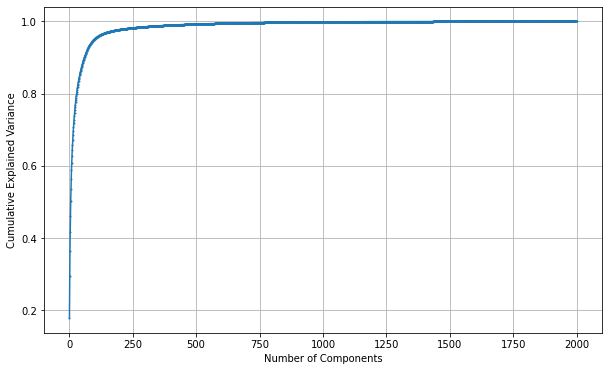

In [45]:
#cumulative plot to choose an optimum n_components with least omitted data
fig = plt.figure(figsize=(10,6))
plt.plot(range(1, X_train.shape[0]+1), evr.cumsum(), marker='o',markersize=1)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [11]:
pca = PCA(n_components=300)
X_spec_train_pca = pca.fit_transform(X_spec_train_scale)
X_spec_test_pca = pca.transform(X_spec_test_scale)
print(X_spec_train_pca.shape)

(2000, 300)


## Hyperparameter tuning with PCA dimension reduction

In [13]:
param_grid = {
    'max_depth': [20, 30, 40, 50, 60],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 400, 500],
    'max_features': [70, 90, 110, 130, 150]
}

rf = RandomForestClassifier()

clf = RandomizedSearchCV(estimator = rf, param_distributions = param_grid,
                         cv = 5, scoring='accuracy', n_iter=20, n_jobs = -1,
                   verbose=2, random_state=0,return_train_score=True)
clf.fit(X_spec_train_pca, y_train)
pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,parameters,validation_score,train_score,rank
0,"{'n_estimators': 300, 'min_samples_split': 12,...",0.7710,0.985250,15
1,"{'n_estimators': 300, 'min_samples_split': 12,...",0.7675,0.979875,18
2,"{'n_estimators': 400, 'min_samples_split': 10,...",0.7825,0.994875,5
3,"{'n_estimators': 400, 'min_samples_split': 10,...",0.7805,0.983500,6
4,"{'n_estimators': 300, 'min_samples_split': 10,...",0.7865,0.983500,2
5,"{'n_estimators': 500, 'min_samples_split': 12,...",0.7800,0.991875,7
6,"{'n_estimators': 300, 'min_samples_split': 8, ...",0.7765,0.995500,11
7,"{'n_estimators': 300, 'min_samples_split': 10,...",0.7885,0.996500,1
8,"{'n_estimators': 400, 'min_samples_split': 8, ...",0.7840,0.997000,4
9,"{'n_estimators': 500, 'min_samples_split': 8, ...",0.7795,0.989875,8


In [14]:
df = pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})
df_path = os.path.join(phase2b_path,'cv_result_phase2b_pca300_RandomForest.csv')
df.to_csv(df_path, index=False)

In [15]:
print(clf.best_params_)
y_pred = clf.predict(X_spec_test_pca)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 90, 'max_depth': 40}
0.774
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.91      0.82      0.86        50
           2       0.84      0.76      0.80        50
           3       0.74      0.78      0.76        50
           4       0.77      0.74      0.76        50
           5       0.77      0.72      0.74        50
           6       0.76      0.88      0.81        50
           7       0.69      0.66      0.67        50
           8       0.79      0.68      0.73        50
           9       0.70      0.80      0.75        50

    accuracy                           0.77       500
   macro avg       0.78      0.77      0.77       500
weighted avg       0.78      0.77      0.77       500



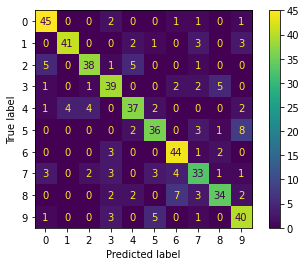

In [16]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
plt.show()

## Hyperparameter tuning without PCA dimension reduction

In [17]:

param_grid = {
    'max_depth': [20, 30, 40, 50, 60, 80],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300, 400, 500],
    'max_features': [200,400,600,800,1000]
}

rf2 = RandomForestClassifier()

clf2 = RandomizedSearchCV(estimator = rf2, param_distributions = param_grid,
                         cv = 5, scoring='accuracy', n_iter=20, n_jobs = -1,
                   verbose=2, random_state=0,return_train_score=True)
clf2.fit(X_spec_train_scale, y_train)
pd.DataFrame({'parameters': clf2.cv_results_["params"],
              'validation_score': clf2.cv_results_["mean_test_score"],
              'train_score': clf2.cv_results_["mean_train_score"],
              'rank': clf2.cv_results_["rank_test_score"]})

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,parameters,validation_score,train_score,rank
0,"{'n_estimators': 400, 'min_samples_split': 10,...",0.8805,0.992500,1
1,"{'n_estimators': 400, 'min_samples_split': 12,...",0.8705,0.979000,7
2,"{'n_estimators': 500, 'min_samples_split': 12,...",0.8760,0.991125,3
3,"{'n_estimators': 400, 'min_samples_split': 10,...",0.8690,0.981125,11
4,"{'n_estimators': 300, 'min_samples_split': 10,...",0.8635,0.981500,20
5,"{'n_estimators': 400, 'min_samples_split': 12,...",0.8725,0.984375,5
6,"{'n_estimators': 500, 'min_samples_split': 12,...",0.8640,0.982125,18
7,"{'n_estimators': 500, 'min_samples_split': 10,...",0.8695,0.987125,10
8,"{'n_estimators': 500, 'min_samples_split': 10,...",0.8730,0.986625,4
9,"{'n_estimators': 400, 'min_samples_split': 12,...",0.8645,0.981250,17


In [19]:
df = pd.DataFrame({'parameters': clf2.cv_results_["params"],
              'validation_score': clf2.cv_results_["mean_test_score"],
              'train_score': clf2.cv_results_["mean_train_score"],
              'rank': clf2.cv_results_["rank_test_score"]})
df_path = os.path.join(phase2b_path,'cv_result_phase2b_4096_RandomForest.csv')
df.to_csv(df_path, index=False)

In [20]:
print(clf2.best_params_)
y_pred = clf2.predict(X_spec_test_scale)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 200, 'max_depth': 80}
0.87
              precision    recall  f1-score   support

           0       0.91      0.98      0.94        50
           1       0.82      0.82      0.82        50
           2       0.87      0.90      0.88        50
           3       0.89      0.84      0.87        50
           4       0.93      0.84      0.88        50
           5       0.82      0.82      0.82        50
           6       0.80      0.90      0.85        50
           7       0.88      0.86      0.87        50
           8       0.90      0.86      0.88        50
           9       0.90      0.88      0.89        50

    accuracy                           0.87       500
   macro avg       0.87      0.87      0.87       500
weighted avg       0.87      0.87      0.87       500



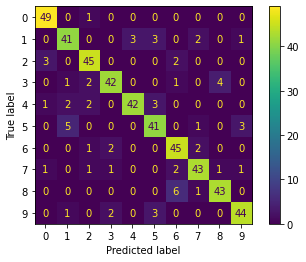

In [21]:
cm = confusion_matrix(y_test, y_pred, labels=clf2.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf2.classes_)
disp.plot()
plt.show()

## Hyperparameter tuning for SVM

In [6]:
param_grid = {
    'C': [1, 10, 100, 500, 1000],
    'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
}

clf3 = GridSearchCV(estimator=SVC(), param_grid=param_grid,cv = 5, 
                    scoring='accuracy', n_jobs = -1,return_train_score=True)
clf3.fit(X_spec_train_scale, y_train)
pd.DataFrame({'parameters': clf3.cv_results_["params"],
              'validation_score': clf3.cv_results_["mean_test_score"],
              'train_score': clf3.cv_results_["mean_train_score"],
              'rank': clf3.cv_results_["rank_test_score"]})

,parameters,validation_score,train_score,rank
0,"{'C': 1, 'gamma': 0.1}",0.1350,1.000000,25
1,"{'C': 1, 'gamma': 0.01}",0.4000,1.000000,20
2,"{'C': 1, 'gamma': 0.001}",0.8205,0.979375,12
3,"{'C': 1, 'gamma': 0.0001}",0.8075,0.857125,14
4,"{'C': 1, 'gamma': 1e-05}",0.5450,0.568375,15
5,"{'C': 10, 'gamma': 0.1}",0.1455,1.000000,21
6,"{'C': 10, 'gamma': 0.01}",0.4285,1.000000,16
7,"{'C': 10, 'gamma': 0.001}",0.8480,1.000000,8
8,"{'C': 10, 'gamma': 0.0001}",0.9010,0.976375,6
9,"{'C': 10, 'gamma': 1e-05}",0.8165,0.857625,13


In [7]:
df = pd.DataFrame({'parameters': clf3.cv_results_["params"],
              'validation_score': clf3.cv_results_["mean_test_score"],
              'train_score': clf3.cv_results_["mean_train_score"],
              'rank': clf3.cv_results_["rank_test_score"]})
df_path = os.path.join(phase2b_path,'cv_result_phase2b_4096_SVM.csv')
df.to_csv(df_path, index=False)

In [8]:
print(clf3.best_params_)
y_pred = clf3.predict(X_spec_test_scale)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'C': 100, 'gamma': 0.0001}
0.926
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        50
           1       0.96      0.92      0.94        50
           2       0.96      0.96      0.96        50
           3       0.85      0.94      0.90        50
           4       0.96      0.94      0.95        50
           5       0.94      0.90      0.92        50
           6       0.88      0.88      0.88        50
           7       0.94      0.96      0.95        50
           8       0.96      0.90      0.93        50
           9       0.87      0.94      0.90        50

    accuracy                           0.93       500
   macro avg       0.93      0.93      0.93       500
weighted avg       0.93      0.93      0.93       500



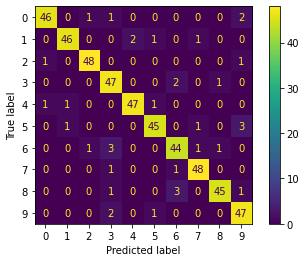

In [9]:
cm = confusion_matrix(y_test, y_pred, labels=clf3.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf3.classes_)
disp.plot()
plt.show()

In [10]:
model_path = os.path.join(phase2b_path,'Model_Phase2b.pkl')
with open(model_path, 'wb') as f:
    pickle.dump(clf3, f)

# ث)

In [16]:
def predict_phase2b(test_path, phase1_path, phase2b_path, len_train):
  #load train data spectrogram and labels 
  X_spec_train = np.load(os.path.join(phase2b_path,'phase2b_Xtrain_spec.npy'))
  y_train = np.load(os.path.join(phase1_path,'phase1_ytrain.npy'))
  #read test data from directory and preprocess
  X_test,y_test,len_test = preprocess(test_path,len_train)
  #calculate STFT test data in dBs
  X_spec_test = np.zeros([X_test.shape[0],64,64])
  print(X_spec_test.shape)
  for i in range(X_test.shape[0]):
    S = np.abs(librosa.stft(X_test[i], n_fft=127, hop_length=(X_test.shape[1]//64)+1))
    stft = librosa.amplitude_to_db(S, ref=np.max)
    X_spec_test[i] = stft
  #reshape STFT data from 2D to 1D
  X_spec_test = X_spec_test.reshape(X_test.shape[0],-1,order='F')
  print(X_spec_test.shape)
  #normalize train data and transform test data
  scalar = StandardScaler()
  X_spec_train_scale = scalar.fit_transform(X_spec_train)
  X_spec_test_scale = scalar.transform(X_spec_test)

  #load model
  model_path = os.path.join(phase2b_path,'Model_Phase2b.pkl')
  with open(model_path, 'rb') as f: 
    clf = pickle.load(f)
  #predic test data labels
  y_pred = clf.predict(X_spec_test_scale)
  #save predicted labels
  np.save(os.path.join(phase2b_path,'phase2b_predicted.npy'),y_pred)

  #return accuracy
  return accuracy_score(y_test,y_pred)


root = os.getcwd()
phase1_path = os.path.join(root,'Phase_1')
phase2b_path = os.path.join(root,'Phase_2b')
test_path = os.path.join(dataset_path,'test')

length = 4783


acc = predict_phase2b(test_path,phase1_path, phase2b_path, length)
print("accuracy on test data: ", acc)

4783

(500, 64, 64)
(500, 4096)
accuracy on test data:  0.926


# PHASE 3

#  الف)

In [17]:
X_spec_train = np.load(os.path.join(phase2b_path,'phase2b_Xtrain_spec.npy'))
X_spec_test = np.load(os.path.join(phase2b_path,'phase2b_Xtest_spec.npy'))
y_train = np.load(os.path.join(phase1_path,'phase1_ytrain.npy'))
y_test = np.load(os.path.join(phase1_path,'phase1_ytest.npy'))

In [27]:
X_spec_train50 = np.zeros([50,4096])
y_train50 = np.zeros(50)

for i in range(10):
  #choose 5 random numbers
  rd = random.sample(range(i*200, (i+1)*200), 5)
  print(rd)
  for j in range(5):
    X_spec_train50[i*5+j] = X_spec_train[int(rd[j])]
    y_train50[i*5+j] = i




[124, 89, 193, 51, 164]
[271, 373, 363, 344, 232]
[422, 468, 474, 550, 477]
[765, 722, 750, 629, 603]
[859, 968, 913, 935, 820]
[1167, 1035, 1122, 1154, 1120]
[1388, 1269, 1337, 1341, 1296]
[1520, 1491, 1552, 1430, 1420]
[1600, 1617, 1727, 1713, 1630]
[1848, 1875, 1976, 1838, 1984]


In [28]:
sc = StandardScaler()
X_spec_train50_scale = sc.fit_transform(X_spec_train50)
X_spec_test_scale = sc.transform(X_spec_test)

## Hyperparameter tuning without PCA

In [37]:
pipe = Pipeline(steps=[('estimator', SVC())])

#a dict of estimator and estimator related parameters in this list
params_grid = [{
                'estimator':[SVC()],
                'estimator__kernel': ['linear', 'rbf'],
                'estimator__C': [10, 100, 1000],
                'estimator__gamma': [1e-3, 1e-4, 1e-5]
                },
                {
                'estimator': [RandomForestClassifier()],
                'estimator__n_estimators' : [50,100,150,200],
                'estimator__min_samples_leaf': [2,3,4],
                'estimator__max_features': [50,200,1000,2000],
                'estimator__min_samples_split' : [2,3,4],
                'estimator__random_state': [0]
                },
                {
                'estimator':[KNeighborsClassifier()],
                'estimator__n_neighbors':[3,4,5],
                'estimator__weights': ['uniform', 'distance']
                },
               {
                'estimator': [LogisticRegression()],
                'estimator__random_state': [0],
                'estimator__penalty': ['elasticnet'],
                'estimator__solver': ['saga'],
                'estimator__l1_ratio': [0.3,0.4,0.5],
                'estimator__C': [1,10,100]
               },
               {
                'estimator': [GaussianNB()]
               }

              ]

clf = GridSearchCV(pipe, params_grid, scoring='accuracy',
                   n_jobs=-1,cv=5,
                   return_train_score=True)

clf.fit(X_spec_train50_scale, y_train50)
pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})

,parameters,validation_score,train_score,rank
0,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,1.00,154
1,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.44,1.00,168
2,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,1.00,154
3,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,0.98,154
4,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,1.00,154
...,...,...,...,...
173,"{'estimator': LogisticRegression(), 'estimator...",0.48,1.00,142
174,"{'estimator': LogisticRegression(), 'estimator...",0.48,1.00,142
175,"{'estimator': LogisticRegression(), 'estimator...",0.48,1.00,142
176,"{'estimator': LogisticRegression(), 'estimator...",0.48,1.00,142


In [38]:
df = pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})
df_path = os.path.join(phase3_path,'cv_result_phase3_4096.csv')
df.to_csv(df_path, index=False)

In [39]:
print(clf.best_params_)
y_pred = clf.predict(X_spec_test_scale)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'estimator': RandomForestClassifier(max_features=200, min_samples_leaf=4, random_state=0), 'estimator__max_features': 200, 'estimator__min_samples_leaf': 4, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'estimator__random_state': 0}
0.518
              precision    recall  f1-score   support

           0       0.88      0.58      0.70        50
           1       0.54      0.28      0.37        50
           2       0.46      0.48      0.47        50
           3       0.35      0.34      0.35        50
           4       0.54      0.74      0.63        50
           5       0.60      0.68      0.64        50
           6       0.48      0.50      0.49        50
           7       0.40      0.34      0.37        50
           8       0.42      0.68      0.52        50
           9       0.67      0.56      0.61        50

    accuracy                           0.52       500
   macro avg       0.54      0.52      0.51       500
weighted avg       0.54      0.52  

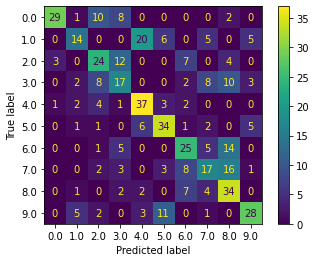

In [40]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
plt.show()

## Hyperparameter tuning with PCA

In [41]:
pca = PCA()
X_spec_train50_pca = pca.fit_transform(X_spec_train50_scale)
X_spec_test_pca = pca.transform(X_spec_test_scale)
print(X_spec_train50_pca.shape)

(50, 50)


In [42]:
pipe2 = Pipeline(steps=[('estimator', SVC())])

# Add a dict of estimator and estimator related parameters in this list
params_grid2 = [{
                'estimator':[SVC()],
                'estimator__kernel': ['linear', 'rbf'],
                'estimator__C': [10, 100, 1000],
                'estimator__gamma': [1e-3, 1e-4, 1e-5]
                },
                {
                'estimator': [RandomForestClassifier()],
                'estimator__n_estimators' : [50,100,150],
                'estimator__min_samples_leaf': [2,3,4],
                'estimator__max_features': [10,20,30],
                'estimator__min_samples_split' : [2,3,4],
                'estimator__random_state': [0]
                },
                {
                'estimator':[KNeighborsClassifier()],
                'estimator__n_neighbors':[3,4,5],
                'estimator__weights': ['uniform', 'distance']
                },
               {
                'estimator': [LogisticRegression()],
                'estimator__random_state': [0],
                'estimator__penalty': ['elasticnet'],
                'estimator__solver': ['saga'],
                'estimator__l1_ratio': [0,0.2,0.4],
                'estimator__C': [1,10,100]
               },
               {
                'estimator': [GaussianNB()]
               }

              ]

clf2 = GridSearchCV(pipe2, params_grid2, scoring='accuracy',
                   n_jobs=-1,cv=5,
                   return_train_score=True)

clf2.fit(X_spec_train50_pca, y_train50)
pd.DataFrame({'parameters': clf2.cv_results_["params"],
              'validation_score': clf2.cv_results_["mean_test_score"],
              'train_score': clf2.cv_results_["mean_train_score"],
              'rank': clf2.cv_results_["rank_test_score"]})

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


,parameters,validation_score,train_score,rank
0,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,1.00,9
1,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.44,1.00,24
2,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,1.00,9
3,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,0.98,9
4,"{'estimator': SVC(), 'estimator__C': 10, 'esti...",0.46,1.00,9
...,...,...,...,...
110,"{'estimator': LogisticRegression(C=1, l1_ratio...",0.48,1.00,1
111,"{'estimator': LogisticRegression(C=1, l1_ratio...",0.48,1.00,1
112,"{'estimator': LogisticRegression(C=1, l1_ratio...",0.48,1.00,1
113,"{'estimator': LogisticRegression(C=1, l1_ratio...",0.48,1.00,1


# ب,پ,ث)

## با توجه به اینکه این 3 قسمت به هم مرتبط بودند، با هم انجام و بررسی شدند.

In [47]:
scalar = StandardScaler()
X_spec_train_scale = scalar.fit_transform(X_spec_train)
X_spec_test_scale = scalar.transform(X_spec_test)

## Without PCA

# ب)

In [74]:

km = KMeans(n_clusters=50,max_iter=300,n_init=1000,random_state=0).fit(X_spec_train_scale)

In [75]:
#distance of each sample to cluster centers
dist = km.transform(X_spec_train_scale)
print(dist.shape)

(2000, 50)


In [76]:
#cluster label for each sample
labels = km.predict(X_spec_train_scale)

In [92]:
#count of samples in each cluster
cluster_count = np.zeros(50)
for i in range(2000):
  cluster_count[labels[i]] +=1
cluster_count

array([138.,  70.,  65.,   1., 123., 101.,  23.,   3.,   1.,  34.,   1.,
         1.,  28.,   9.,   1.,   1.,   1.,  16.,   1., 132.,  10.,  57.,
        86.,   4.,  87.,  71.,   1.,   4.,  56.,  78.,  65.,   1., 123.,
       127.,  27.,   1.,   4.,  19.,   1., 114., 106.,  40.,  18.,   5.,
         1.,  60.,  70.,   4.,   6.,   4.])

In [153]:
X_spec_tain50_KM = np.zeros([50,4096])
y_train50_KM = np.zeros(50,dtype=int)
label_train50 = np.zeros(50,dtype=int)
for i in range(50):
  d = dist[:, i] #distance of all samples to cluster 0 center
  index = np.argsort(d)[::][0] #least distance : nearest sample to cluster
  X_spec_tain50_KM[i] = X_spec_train[index]
  #0: 0-199, 1: 200:399, 2: 400:599 ...
  y_train50_KM[i] = index//200
  label_train50[i] = labels[index]

  print('cluster label:',label_train50[i],
        'index: ',index,
        'real label:',y_train50_KM[i])


cluster label: 0 index:  1480 real label: 7
cluster label: 1 index:  1897 real label: 9
cluster label: 2 index:  28 real label: 0
cluster label: 3 index:  30 real label: 0
cluster label: 4 index:  1125 real label: 5
cluster label: 5 index:  1669 real label: 8
cluster label: 6 index:  59 real label: 0
cluster label: 7 index:  1171 real label: 5
cluster label: 8 index:  517 real label: 2
cluster label: 9 index:  943 real label: 4
cluster label: 10 index:  1973 real label: 9
cluster label: 11 index:  1922 real label: 9
cluster label: 12 index:  126 real label: 0
cluster label: 13 index:  65 real label: 0
cluster label: 14 index:  1983 real label: 9
cluster label: 15 index:  841 real label: 4
cluster label: 16 index:  1869 real label: 9
cluster label: 17 index:  1048 real label: 5
cluster label: 18 index:  451 real label: 2
cluster label: 19 index:  1451 real label: 7
cluster label: 20 index:  862 real label: 4
cluster label: 21 index:  146 real label: 0
cluster label: 22 index:  1304 real

In [154]:
np.save(os.path.join(phase3_path,'phase3_Xtrain50_spec_KM.npy'),X_spec_tain50_KM)
np.save(os.path.join(phase3_path,'phase3_ytrain50_KM.npy'),y_train50_KM)

In [147]:
#count of each class samples in the 50 samples taken from clustering
count_train50 = np.zeros(10)
for i in range(50):
  count_train50[y_train50_KM[i]] +=1
count_train50

array([13.,  2.,  5.,  1.,  5.,  5.,  4.,  2.,  3., 10.])

# ث)

In [152]:
#labels given according to KMeans
y_train_KM = np.zeros(2000,dtype=int)
err = 0
class_err = np.zeros(10)
for i in range(50):
  #indices of all cluster i samples
  idx = np.where(km.labels_ == i)[0] 
  for j in range(idx.shape[0]) :
    if idx[j]//200 != y_train50_KM[i] : #predicted label is no correct
      err +=1
      class_err[idx[j]//200] +=1
  #set the labels according the label of the representative sample
  y_train_KM[idx] = y_train50_KM[i] 

print('accuracy of labeling:', 1-(err/2000))
print('accuracy of labeling in each class:')
print(1-class_err/200)

accuracy of labeling: 0.41900000000000004
accuracy of labeling in each class:
[0.82  0.425 0.405 0.06  0.365 0.45  0.655 0.3   0.435 0.275]


In [80]:
#count of each class samples after labeling with KMeans
count_train = np.zeros(10)
for i in range(2000):
  count_train[int(y_train_KM[i])] +=1
count_train

array([260., 185., 136.,  19., 123., 307., 406., 270., 170., 124.])

## With PCA

# ب)

In [138]:
pca = PCA(n_components=200)
X_spec_train_pca = pca.fit_transform(X_spec_train_scale)

In [139]:
km2 = KMeans(n_clusters=50,max_iter=500,n_init=1000,random_state=0).fit(X_spec_train_pca)
dist2 = km2.transform(X_spec_train_pca)
print(dist2.shape)

(2000, 50)


In [140]:
labels2 = km2.predict(X_spec_train_pca)

In [141]:
#count of samples in each cluster
cluster_count = np.zeros(50)
for i in range(2000):
  cluster_count[labels2[i]] +=1
cluster_count

array([ 91.,  31.,   1.,   1.,   1.,  10.,  75.,  94.,  69.,   1.,  26.,
       130.,   3., 120.,   1.,   1.,  11.,  24.,   1.,  48., 126.,  27.,
        95.,   1.,   1., 110., 100.,   1.,   2.,   3.,  43.,  29.,   1.,
       117.,   1.,  23.,   4.,  54.,   1.,  74., 162.,   4.,   1.,  16.,
         3., 107.,   3.,   8.,  10., 134.])

# پ)

In [142]:
X_spec_tain50_KM = np.zeros([50,4096])
y_train50_KM = np.zeros(50)
label_train50 = np.zeros(50,dtype=int)
for i in range(50):
  d = dist2[:, i] #distance of all samples to cluster 0 center
  index = np.argsort(d)[::][0] #least distance : nearest sample to cluster
  X_spec_tain50_KM[i] = X_spec_train[index]
  y_train50_KM[i] = index//200
  label_train50[i] = labels2[index]

  print('cluster label:',label_train50[i],' index: ',index,' real label:',y_train50_KM[i])

cluster label: 0  index:  1409  real label: 7.0
cluster label: 1  index:  943  real label: 4.0
cluster label: 2  index:  1973  real label: 9.0
cluster label: 3  index:  30  real label: 0.0
cluster label: 4  index:  517  real label: 2.0
cluster label: 5  index:  922  real label: 4.0
cluster label: 6  index:  79  real label: 0.0
cluster label: 7  index:  1125  real label: 5.0
cluster label: 8  index:  263  real label: 1.0
cluster label: 9  index:  841  real label: 4.0
cluster label: 10  index:  38  real label: 0.0
cluster label: 11  index:  1564  real label: 7.0
cluster label: 12  index:  1171  real label: 5.0
cluster label: 13  index:  1311  real label: 6.0
cluster label: 14  index:  451  real label: 2.0
cluster label: 15  index:  77  real label: 0.0
cluster label: 16  index:  172  real label: 0.0
cluster label: 17  index:  1989  real label: 9.0
cluster label: 18  index:  22  real label: 0.0
cluster label: 19  index:  360  real label: 1.0
cluster label: 20  index:  1604  real label: 8.0

In [143]:
count = np.zeros(10)
for i in range(50):
  count[int(y_train50_KM[i])] +=1
count

array([10.,  4.,  5.,  1.,  4.,  3.,  1.,  5.,  3., 14.])

# ث)

In [144]:
#labels given according to KMeans
y_train_KM = np.zeros(2000)
err = 0
for i in range(50):
  #indices of all cluster i samples
  idx = np.where(km2.labels_ == i)[0] 
  for j in range(idx.shape[0]) :
    if idx[j]//200 != int(y_train50_KM[i]) : #predicted label is no correct
      err +=1
  #set the labels according the label of the representative sample
  y_train_KM[idx] = y_train50_KM[i] 

print('accuracy of labeling:', 1-(err/2000))

accuracy of labeling: 0.372


In [145]:
#count of each class samples after labeling with KMeans
count_train = np.zeros(10)
for i in range(2000):
  count_train[int(y_train_KM[i])] +=1
count_train

array([238., 334.,  40., 100.,  50., 151., 120., 540., 246., 181.])

# ج)

In [ ]:
param_grid = {
    'C': [1, 10, 100, 500, 1000],
    'gamma': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
}

clf = GridSearchCV(estimator=SVC(), param_grid=param_grid,cv = 5, 
                    scoring='accuracy', n_jobs = -1,return_train_score=True)
clf.fit(X_spec_train_scale, y_train_KM)


In [157]:
pd.DataFrame({'parameters': clf.cv_results_["params"],
              'validation_score': clf.cv_results_["mean_test_score"],
              'train_score': clf.cv_results_["mean_train_score"],
              'rank': clf.cv_results_["rank_test_score"]})

,parameters,validation_score,train_score,rank
0,"{'C': 1, 'gamma': 0.1}",0.2030,1.000000,21
1,"{'C': 1, 'gamma': 0.01}",0.2410,1.000000,20
2,"{'C': 1, 'gamma': 0.001}",0.8360,0.993750,11
3,"{'C': 1, 'gamma': 0.0001}",0.8255,0.929375,13
4,"{'C': 1, 'gamma': 1e-05}",0.6935,0.750500,15
5,"{'C': 10, 'gamma': 0.1}",0.2030,1.000000,21
6,"{'C': 10, 'gamma': 0.01}",0.2510,1.000000,16
7,"{'C': 10, 'gamma': 0.001}",0.8490,1.000000,5
8,"{'C': 10, 'gamma': 0.0001}",0.8550,0.983000,4
9,"{'C': 10, 'gamma': 1e-05}",0.8235,0.917875,14


In [156]:
print(clf.best_params_)
y_pred = clf.predict(X_spec_test_scale)
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test, y_pred))

{'C': 500, 'gamma': 0.0001}
0.376
              precision    recall  f1-score   support

           0       0.58      0.88      0.70        50
           1       0.42      0.32      0.36        50
           2       0.61      0.38      0.47        50
           3       0.20      0.02      0.04        50
           4       0.44      0.22      0.29        50
           5       0.24      0.42      0.30        50
           6       0.35      0.70      0.47        50
           7       0.11      0.12      0.12        50
           8       0.44      0.40      0.42        50
           9       0.38      0.30      0.34        50

    accuracy                           0.38       500
   macro avg       0.38      0.38      0.35       500
weighted avg       0.38      0.38      0.35       500



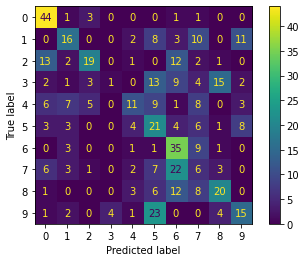

In [158]:
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=clf.classes_)
disp.plot()
plt.show()